# Measuring the Mass-Ratio Distribution in Real Data
This notebook will eventually contain the code that runs my real data through the pipeline I have developed. For now, I am using it to combined all the literature data with my measurements to make plots for my committee meeting...

In [1]:
from __future__ import print_function, division, absolute_import
import pandas as pd
from kglib.utils import HelperFunctions, plottools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from astroquery.vizier import Vizier
import logging
from astropy.time import Time 
import seaborn as sns
sns.set_context('talk', font_scale=1.5)
sns.set_style('white')

logger = logging.getLogger()
logger.setLevel(logging.WARN)
%matplotlib inline

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Read in my companion data
my_companion_data = pd.read_csv('Corrected_Companion_Data.csv', sep='|', index_col=0).drop_duplicates(subset=['Star'])
my_companion_data['q'] = my_companion_data.Mass / my_companion_data.M1
my_companion_data[['Star', 'SpT', 'configuration', 'M1', 'Corrected_Temperature', 'Mass', 'q']].head()

,Star,SpT,configuration,M1,Corrected_Temperature,Mass,q
0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,2.5,5732.020192,0.999831,0.399932
2,HIP 3478,B5V,B5V,4.6,5524.152869,0.957460,0.208143
3,HIP 5310,A3V,(A3V + ?; ?),2.0,3342.732718,0.352539,0.176269
4,HR 545,B9.5IV,B9V,2.5,4312.191145,0.728462,0.291385
7,HR 604,B8V+A0V,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,3.4,4735.568122,0.794541,0.233688


In [3]:
# Read in my full sample
sample = HelperFunctions.read_observed_targets()[['identifier', 'RA/DEC (J2000)', 'plx', 'Vmag', 'Kmag',
                                                  'vsini', 'SpT', 'configuration']]
sample.head()

,identifier,RA/DEC (J2000),plx,Vmag,Kmag,vsini,SpT,configuration
1,HIP 813,00 10 02.20293 +11 08 44.9280,10.68,5.537,NaN,249,B9Vn,"(5.5B9Vn + 10.0G5Ve; 7.7"")"
2,HIP 1191,00 14 54.51542 -09 34 10.4503,9.63,5.757,5.941,128,B8.5V,B9V
3,HIP 1366,00 17 05.49885 +38 40 53.8902,10.56,4.619,4.416,102,A2V,"(A2V + ?; .06"")"
4,HIP 1647,00 20 39.03682 -69 37 29.6821,10.25,5.498,5.497,236,B9V,"(B9V + K10.1XR; 2.28"")"
5,HIP 2381,00 30 22.65465 -23 47 15.6501,18.83,5.190,4.830,167,A3V,A3V


# Compare my sample to stars in SB9

In [4]:

def check_sb9(starname):
    query_result = Vizier.query_object(starname, catalog='B/sb9/main')
    if len(query_result) == 0:
        return pd.DataFrame(data=dict(star=starname, sb9_binary=False, separation=np.nan, K1=np.nan), index=[0])
    K1 = []
    K2 = []
    for i in range(len(query_result[0])):
        orbit = Vizier.query_constraints(catalog='B/sb9/orbits', Seq=query_result[0]['Seq'][i])[0]
        orbit['K1'].fill_value = np.nan
        orbit['K2'].fill_value = np.nan
        for j in range(len(orbit)):
            K1.append(orbit.filled()['K1'][j])
            K2.append(orbit.filled()['K2'][j])
    N = len(K1)
    binarity = [True]*N
    separation = [np.nan]*N
    return pd.DataFrame(data=dict(star=[starname]*N, wds_binary=binarity, separation=separation, K1=K1, K2=K2), index=range(N))

tmp = sample.drop_duplicates(subset=['identifier']).identifier.map(check_sb9)
sb9_binarity= pd.concat([tmp[i] for i in tmp.index], ignore_index=True)
sb9_binarity['q'] = sb9_binarity.K1 / sb9_binarity.K2
sb9_binarity.head()

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/astroquery/vizier/core.py:567: UserWarning: VOTABLE parsing raised exception: 
  warnings.warn("VOTABLE parsing raised exception: {0}".format(ex))


,K1,K2,sb9_binary,separation,star,wds_binary,q
0,NaN,NaN,False,NaN,HIP 813,NaN,NaN
1,NaN,NaN,False,NaN,HIP 1191,NaN,NaN
2,NaN,NaN,False,NaN,HIP 1366,NaN,NaN
3,NaN,NaN,False,NaN,HIP 1647,NaN,NaN
4,NaN,NaN,False,NaN,HIP 2381,NaN,NaN


In [5]:
# Combine to make a companion data dataframe
sb9 = sb9_binarity.rename(columns=dict(star='Star', K1='SB9_K1', K2='SB9_K2', q='SB9_q')).dropna(subset=['SB9_q'])
for col in ['SB9_K1', 'SB9_K2', 'SB9_q']:
    sb9[col] = pd.to_numeric(sb9[col], errors='raise')
highq = sb9.SB9_q > 1
sb9.loc[highq, 'SB9_q'] = 1.0/sb9.loc[highq, 'SB9_q']
companions = pd.merge(my_companion_data, sb9[['Star', 'SB9_K1', 'SB9_K2', 'SB9_q']], how='outer', on='Star')
companions[['Star', 'SpT', 'configuration', 'M1', 'Corrected_Temperature', 'Mass', 'q', 'SB9_q']].head(10)

,Star,SpT,configuration,M1,Corrected_Temperature,Mass,q,SB9_q
0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,2.50,5732.020192,0.999831,0.399932,NaN
1,HIP 3478,B5V,B5V,4.60,5524.152869,0.957460,0.208143,NaN
2,HIP 5310,A3V,(A3V + ?; ?),2.00,3342.732718,0.352539,0.176269,NaN
3,HR 545,B9.5IV,B9V,2.50,4312.191145,0.728462,0.291385,NaN
4,HR 604,B8V+A0V,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,3.40,4735.568122,0.794541,0.233688,0.797872
5,HIP 10732,A1Vn,A1Vn,2.20,5577.861816,0.969563,0.440710,NaN
6,HIP 12332,A7V,A7V,1.76,5550.502051,0.966201,0.548978,NaN
7,HIP 12706,A2Vn+F4V,"((3.56A3V + 6.63F3V; 2.600"") + 10.16K5; 840"")",2.10,6050.532584,1.144096,0.544808,NaN
8,HIP 13165,B6V,((5.30(B6V + ?; 3.854d e=.04) + 8.46A0Vp; 3...,4.00,5772.983560,1.000638,0.250159,NaN
9,HIP 13327,B7V,B7V,3.90,5524.338388,0.957545,0.245524,NaN


In [6]:
companions.loc[(companions.q.notnull()) & (companions.SB9_q.notnull())][['Star', 'configuration', 'q', 'SB9_q']]

,Star,configuration,q,SB9_q
4,HR 604,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,0.233688,0.797872
10,HIP 14576,((6.0G8IV + 2.2B8V; 2.87d SD) + 4.72F1; 1.8...,0.434953,0.218905
11,HIP 14576,((6.0G8IV + 2.2B8V; 2.87d SD) + 4.72F1; 1.8...,0.434953,0.379747
15,HIP 16611,(B8V + B8V; 6.224d e=.20),0.333679,0.962617
18,HIP 18724,"((A4IV + B3V; 3.953d SD) + ?; 33.03d, e=0.15)",0.266797,0.266167
44,HIP 76267,(B9.5IV + G2V; 17.36d e=.37),0.421103,0.357576
47,HIP 78820,"(2.59((B0.5V + B; 6.828d e=.29) + 5.9; .5"")...",0.088998,0.632828
48,HIP 78821,"(2.59((B0.5V + B; 6.828d e=.29) + 5.9; .5"")...",0.113294,0.632828


There is a small amount of overlap where both I and SB9 find companions with a measureable q. 

- HIP 14576: There are two companions, I detect the more massive of the two. I will just nanify my companions.
- HR 604: I detect what is likely the K3 companion, which is different than the one given by SB9 so I will keep both
- HIP 16611: These are apparently different companions. For now I am not paying attention to how likely my detections are false positives...
- HIP 18724: Same companion. I will nanify my detection since the dynamical constrant is better
- HIP 76267: Same as above
- HIP 78820, HIP 78821: The SB9 data is for the same companion, while mine is for a different companion? I will nanify one of the SB9 ones and one of mine

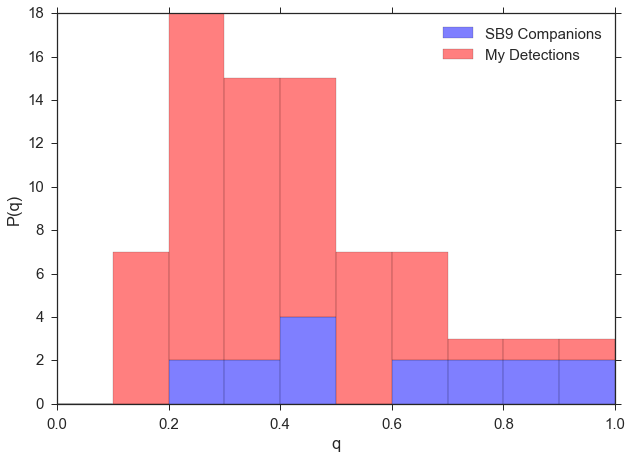

In [7]:
companions.loc[[10, 11, 18, 44, 47], 'q'] = np.nan
companions.loc[47, 'SB9_q'] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(10,7))
bins = np.arange(0, 1.1, 0.1)
low, _, _ = ax.hist(companions.SB9_q.dropna().values, bins=bins, color='blue', alpha=0.5, label='SB9 Companions')
ax.hist(companions.q.dropna().values, bins=bins, bottom=low, color='red', alpha=0.5, label='My Detections')
leg = ax.legend(loc='best', fancybox=True)
ax.set_xlabel('q')
ax.set_ylabel('P(q)')
plt.savefig('Figures/CombinedMassRatios.pdf')
#companions.SB9_q.hist(bins=bins, color='blue', alpha=0.5)

# Add in WDS data
I have compiled a bunch of data from the WDS interferometry (which is really just the WDS but where they give every measurement instead of a summary that leaves out a lot). I will read that in, and use the delta-m measurements to estimate the mass ratio of the systems.

In [8]:
wds = pd.read_excel('/home/kgullikson/Dropbox/School/Research/Databases/Imaging/WDS_Imaging_Data_Checked.xls', 
              sheetname=0)
wds[['star', 'wds_comp', 'epoch', 'mag1', 'mag1_err', 'mag2', 'mag2_err', 'filt_lam', 'filt_fwhm']].head()

,star,wds_comp,epoch,mag1,mag1_err,mag2,mag2_err,filt_lam,filt_fwhm
0,HIP 1366,AB,1986.8969,NaN,NaN,NaN,NaN,549,22
1,HIP 1366,AB,1989.7174,NaN,NaN,NaN,NaN,549,22
2,HIP 1366,AB,1991.8934,NaN,NaN,NaN,NaN,549,22
3,HIP 1366,AB,1991.9016,NaN,NaN,NaN,NaN,508,41
4,HIP 1366,AB,1996.5378,NaN,NaN,NaN,NaN,549,22


In [9]:
wds = pd.merge(sample[['identifier', 'Vmag', 'SpT', 'configuration']], wds, left_on='identifier', right_on='star', how='right')

In [10]:
wds.loc[wds.mag2.notnull(), ['star', 'wds_comp', 'SpT', 'configuration', 'epoch', 'mag1', 'mag1_err', 'mag2', 'mag2_err', 'filt_lam', 'filt_fwhm']]

,star,wds_comp,SpT,configuration,epoch,mag1,mag1_err,mag2,mag2_err,filt_lam,filt_fwhm
6,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.2000,NaN,NaN,11.700,NaN,1250,380
7,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.2000,NaN,NaN,10.300,NaN,1620,NaN
8,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.2000,NaN,NaN,10.100,NaN,2200,480
9,HIP 2381,AB,A3V,A3V,2005.9300,NaN,NaN,6.206,0.088,2180,60
10,HIP 2381,AB,A3V,A3V,2007.0000,4.830,0.020,11.040,0.090,2150,NaN
11,HIP 2381,AB,A3V,A3V,2007.7300,NaN,NaN,6.229,0.055,2180,60
12,HIP 2381,AB,A3V,A3V,2007.7360,NaN,NaN,6.230,NaN,2180,60
13,HIP 2381,AB,A3V,A3V,2008.7900,NaN,NaN,7.401,0.711,2169,30
143,HIP 2505,AB,B8Vn,"(5.44B7.5Vn + 5.48B8.5V; .446"")",1990.8540,NaN,NaN,0.300,NaN,547,24
144,HIP 2505,AB,B8Vn,"(5.44B7.5Vn + 5.48B8.5V; .446"")",1990.8540,NaN,NaN,0.300,NaN,547,24


In [11]:
import pysynphot
from astropy import units as u, constants
import SpectralTypeRelations
import Mamajek_Table
from scipy.optimize import minimize_scalar

MS = SpectralTypeRelations.MainSequence()
MT = Mamajek_Table.MamajekTable()
MT.mam_df['radius'] = 10**(0.5*MT.mam_df.logL - 2.0*MT.mam_df.logT + 2.0*3.762)
teff2radius = MT.get_interpolator('Teff', 'radius')

def errfcn(Teff2, Teff1, delta_mag, delta_mag_err, bandpass):
    logging.debug(Teff2)
    penalty = 0
    if Teff2 < 500:
        Teff2 = 500
        penalty = 100
        
    R1 = float(teff2radius(Teff1))
    R2 = float(teff2radius(Teff2))
    bb_prim = pysynphot.Icat('ck04models', Teff1, 0.0, 4.0) * R1**2
    obs_prim = pysynphot.Observation(bb_prim, bandpass)
    bb_sec = pysynphot.Icat('ck04models', float(Teff2), 0.0, 4.5) * R2**2
    obs_sec = pysynphot.Observation(bb_sec, bandpass)
    dm = obs_sec.effstim('abmag') - obs_prim.effstim('abmag')
    retval = (dm - delta_mag)**2 / delta_mag_err**2 + penalty
    return retval
    

def get_companion_teff(row):
    logging.info(row['star'])
    delta_mag = row['mag2'] - row['mag1']
    delta_mag_err = np.sqrt(row['mag1_err']**2 + row['mag2_err']**2)
    filt_lam = row['filt_lam']*u.nm.to(u.angstrom)
    filt_fwhm = max(10, row['filt_fwhm'])*u.nm.to(u.angstrom)
    
    filt = pysynphot.Box(filt_lam, filt_fwhm)
    teff1 = MS.Interpolate('Temperature', row['SpT'])
    
    result = minimize_scalar(errfcn, bracket=[4000, 9000], bounds=[3500, 50000], 
                             method='bounded', 
                             args=(teff1, delta_mag, delta_mag_err, filt))
    return result.x

def get_companion_teff_safe(row):
    try:
        return get_companion_teff(row)
    except:
        return np.nan

In [12]:
for col in ['mag1_err', 'mag2_err']:
    wds[col] = wds[col].fillna(value=0.1)
    
wds['mag1'] = wds['mag1'].fillna(value=0)
wds.loc[wds.mag2.notnull(), ['star', 'wds_comp', 'SpT', 'configuration', 'epoch', 'mag1', 'mag1_err', 'mag2', 'mag2_err', 'filt_lam', 'filt_fwhm']].head()

,star,wds_comp,SpT,configuration,epoch,mag1,mag1_err,mag2,mag2_err,filt_lam,filt_fwhm
6,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.20,0.00,0.10,11.700,0.100,1250,380
7,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.20,0.00,0.10,10.300,0.100,1620,NaN
8,HIP 1647,AB,B9V,"(B9V + K10.1XR; 2.28"")",1999.20,0.00,0.10,10.100,0.100,2200,480
9,HIP 2381,AB,A3V,A3V,2005.93,0.00,0.10,6.206,0.088,2180,60
10,HIP 2381,AB,A3V,A3V,2007.00,4.83,0.02,11.040,0.090,2150,NaN


In [13]:
wds['sec_teff'] = np.nan
idx = wds.mag2.notnull()
tmp = wds.loc[idx].apply(get_companion_teff_safe, axis=1)
wds.loc[idx, 'sec_teff'] = tmp

INFO:root:HIP 1647
INFO:root:HIP 1647
INFO:root:HIP 1647
INFO:root:HIP 2381
INFO:root:HIP 2381
INFO:root:HIP 2381
INFO:root:HIP 2381
INFO:root:HIP 2381
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HIP 2505
INFO:root:HI

In [16]:
wds.loc[wds.mag2.notnull(), ['star', 'wds_comp', 'SpT', 'configuration', 'epoch', 'mag1', 'mag1_err', 'mag2', 'mag2_err', 'filt_lam', 'filt_fwhm', 'sec_teff']].tail()

,star,wds_comp,SpT,configuration,epoch,mag1,mag1_err,mag2,mag2_err,filt_lam,filt_fwhm,sec_teff
4048,HIP 118243,AB,B1V,"(4.99B1V + 7.33; 3.140"")",1991.7600,4.991,0.009,7.239,0.010,530,100,15557.523758
4049,HIP 118243,AB,B1V,"(4.99B1V + 7.33; 3.140"")",1991.7600,4.991,0.009,7.239,0.010,530,100,15557.523758
4050,HIP 118243,AB,B1V,"(4.99B1V + 7.33; 3.140"")",1991.7600,4.877,0.014,7.209,0.015,430,90,15572.655001
4051,HIP 118243,AB,B1V,"(4.99B1V + 7.33; 3.140"")",1991.7600,4.877,0.014,7.209,0.015,430,90,15572.655001
4062,,AC,NaN,NaN,2001.7339,0.000,0.100,9.940,0.450,900,340,NaN


In [15]:
wds.loc[wds.sec_teff < 3600, 'sec_teff'] = np.nan
wds_summary = wds.loc[wds.sec_teff.notnull()].groupby(('star', 'wds_comp', 'SpT'))[['sep', 'sec_teff']].mean().reset_index()
wds_summary.rename(columns=dict(star='Star'), inplace=True)
teff2mass = MT.get_interpolator('Teff', 'Msun')
wds_summary['WDS_q'] = teff2mass(wds_summary.sec_teff) / wds_summary.SpT.map(lambda s: MS.Interpolate('Mass', s))
wds_summary.head()

,Star,wds_comp,SpT,sep,sec_teff,WDS_q
0,ADS 3962 AB,AB,B1Vn,31.97300,17689.358263,0.530332
1,HIP 100069,AB,O9IV(n)+B1.5V,1.91863,23254.114889,0.462895
2,HIP 100881,AB,B4V,3.41800,7469.916179,0.294821
3,HIP 101123,A,A1V,21.92000,7810.245772,0.703423
4,HIP 103298,A,A5V,0.22000,4594.121037,0.365857


In [17]:
wds_summary.loc[wds_summary.Star == 'HIP 28691']

,Star,wds_comp,SpT,sep,sec_teff,WDS_q
48,HIP 28691,AB,B8V,0.044825,9740.96669,0.740305


In [18]:
all_companions = pd.merge(companions, wds_summary.loc[wds_summary.sep < 3], on='Star', how='outer')
all_companions.loc[(all_companions.WDS_q.notnull()) & ((all_companions.q.notnull()) | (all_companions.SB9_q.notnull())), ['Star', 'SpT_x', 'configuration', 'wds_comp', 'SB9_K1', 'SB9_K2', 'q', 'SB9_q', 'WDS_q']]

,Star,SpT_x,configuration,wds_comp,SB9_K1,SB9_K2,q,SB9_q,WDS_q
0,HIP 2548,B9.5V,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,"Aa,Ab",NaN,NaN,0.399932,NaN,0.525331
2,HIP 5310,A3V,(A3V + ?; ?),AB,NaN,NaN,0.176269,NaN,0.325180
4,HR 604,B8V+A0V,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,BC,141.000000,112.500000,0.233688,0.797872,0.742607
7,HIP 12706,A2Vn+F4V,"((3.56A3V + 6.63F3V; 2.600"") + 10.16K5; 840"")",AB,NaN,NaN,0.544808,NaN,0.493950
8,HIP 13165,B6V,((5.30(B6V + ?; 3.854d e=.04) + 8.46A0Vp; 3...,"Aa,Ab",NaN,NaN,0.250159,NaN,0.964075
10,HIP 14576,B8V,((6.0G8IV + 2.2B8V; 2.87d SD) + 4.72F1; 1.8...,"Aa,Ab",44.000000,201.000000,NaN,0.218905,0.504431
11,HIP 14576,B8V,((6.0G8IV + 2.2B8V; 2.87d SD) + 4.72F1; 1.8...,"Aa,Ab",12.000000,31.600000,NaN,0.379747,0.504431
13,HIP 16244,B3V,"(4.76B3V + 7.18; .720"")",AB,NaN,NaN,0.179637,NaN,0.312136
21,HIP 21589,A6V,A6V,"Aa,Ab",NaN,NaN,0.420933,NaN,0.299588
23,HIP 22958,B6V,"(5.49B6V + 9.64; .650"")","Aa,Ab",NaN,NaN,0.292996,NaN,0.330446


## More things in common.
I have bolded the WDS companions that I will keep; most of them I throw out since they are weaker constraints than either the dynamical or mine.

- HIP 2548: This is probably the same companion. I trust my data more and will nanify the WDS one.
- HIP 5310: This is probably the same companion; the dynamical constrant is better
- HR 604: This is the same companion as the SB9 one. Nanify the WDS companion
- HIP 12706: Same companion, and mine is better.
- HIP 13165: **Different companion, keep both.**
- HIP 14576: This is the more massive of the SB9 companions. Nanify all WDS ones.
- HIP 16244: Probably the same companion; keep mine
- HIP 21589: Probably same companion; keep mine
- HIP 22958: Same companion; keep mine
- HIP 24244: Probably the same companion. Keep mine.
- HIP 24902: Same companion; keep mine
- HIP 63945: I detect the Aa,Ab companion; nanify the WDS one. **Keep the AC companion though!**
- HIP 77516: Same companion; keep SB9.
- HIP 78821: This might be the same as the companion that I detect. Remove the WDS one.
- HIP 80460: Same companion.
- HIP 85998: Same companion.
- HIP 88818: Same companion
- HIP 103298: Same companion.
- HIP 5348: Probably the same thing?
- HIP 28691: Same companion. This one is actually duplicated in SB9, so delete one of those too.

In [19]:
wds_badindices = [0, 2, 4, 7, 10, 11, 13, 21, 23, 26, 27, 41, 45, 48, 51, 55, 57, 63, 69, 73, 74]
sb9_badindices = [73]
all_companions.loc[wds_badindices, 'WDS_q'] = np.nan
all_companions.loc[sb9_badindices, 'SB9_q'] = np.nan


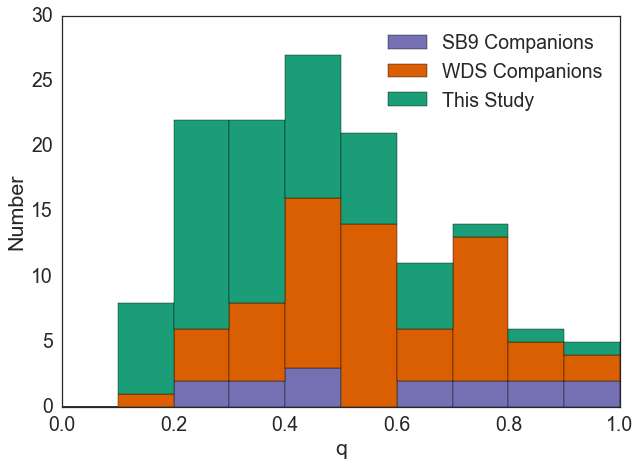

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
bins = np.arange(0, 1.1, 0.1)
low1, _, _ = ax.hist(all_companions.SB9_q.dropna().values, bins=bins, color='#7570b3', alpha=1, label='SB9 Companions')
low2, _, _ = ax.hist(all_companions.WDS_q.dropna().values, bins=bins, bottom=low1, color='#d95f02', alpha=1, label='WDS Companions')
ax.hist(all_companions.q.dropna().values, bins=bins, bottom=low1+low2, color='#1b9e77', alpha=1, label='This Study')

#qplot = np.arange(0.1, 1.01, 0.01)
#N = 50
#gamma = 0.8
#plt.plot(qplot, N*(1-gamma)*qplot**(-gamma))

leg = ax.legend(loc='best', fancybox=True)
ax.set_xlabel('q')
ax.set_ylabel('Number')
plt.savefig('Figures/CombinedMassRatios.pdf')
plt.savefig('Figures/CombinedMassRatios.jpeg')

In [21]:
all_companions.to_csv('AllCompanions.csv')

In [2]:
all_companions = pd.read_csv('AllCompanions.csv')

# Completess-corrected and de-biased histogram

In [2]:
from MassRatioDistribution import Hist
import h5py

In [3]:
# List the stars that I believe
good_hipnums = [100221, 100907, 103298, 10732, 109139, 115115, 12332, 12706, 
                13327, 14764, 16244, 16340, 17563, 19949, 20380, 21589, 22833, 22958,
                23362, 23916, 24902, 25143, 2548, 26126, 32607, 37322, 37450, 38593, 
                38846, 40881, 42129, 46283, 52678, 5310, 72154, 76267, 77336, 
                77516, 79404, 80460, 82673, 84606, 88116, 88817, 88818, 91118, 93805]
binary_starlist = ['HIP {}'.format(n) for n in good_hipnums]
binary_starlist.append('HR 545')

# Make a list of the more complicated multiple systems. Exclude for now, but maybe include later...
multiple_hipnums = [109521, 13165, 14576, 16611, 18724, 26063, 28691, 39847, 5348, 55266,
                    63948, 78820, 79199, 96840]
multiple_starlist = ['HIP {}'.format(n) for n in multiple_hipnums]
multiple_starlist.append('HR 604')

In [4]:
len(binary_starlist), len(multiple_starlist)

(48, 15)

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:689: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


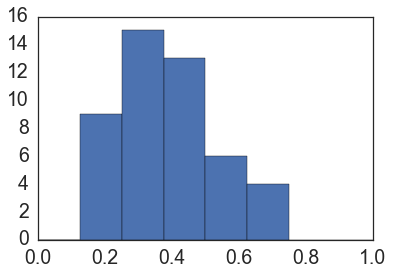

In [5]:
# Read in all of the prior data
prior_hdf5 = 'data/OrbitPrior.h5'
with h5py.File(prior_hdf5, 'r') as f:
    q_list = []
    M2_isolist = []
    M2_sptlist = []
    stars = []
    for starname, star_grp in f.iteritems():
        if starname in binary_starlist:
            M1 = star_grp['primary'].value
            M2_spt = star_grp['companion_spectral_type'].value
            M2_iso = star_grp['companion_isochrone'].value
            M2_sptlist.append(M2_spt)
            q_list.append(M2_iso / M1)
            stars.append(starname)
    
    maxsize = max(a.size for a in q_list)
    q = np.ones((len(q_list), maxsize)) * np.nan
    M2 = np.ones((len(q_list), maxsize)) * np.nan
    for i, (qi, M2i) in enumerate(zip(q_list, M2_sptlist)):
        q[i][:qi.size] = qi
        M2[i][:M2i.size] = M2i

mean_q = np.nanmedian(q, axis=1)
mean_q = mean_q[~np.isnan(mean_q)]
bins = np.linspace(0, 1.0, 9)
_ = plt.hist(mean_q, bins=bins)


# Check which stars were not found
for starname in binary_starlist:
    if starname not in stars:
        print('Did not find data for {}'.format(starname))

In [6]:
# Get completeness
import Completeness
from scipy.interpolate import InterpolatedUnivariateSpline as spline

SELECT * FROM star WHERE name IN ('ADS 3962 AB')
SELECT * FROM star WHERE name IN ('HIP 100069')
SELECT * FROM star WHERE name IN ('HIP 100881')
SELECT * FROM star WHERE name IN ('HIP 101123')
SELECT * FROM star WHERE name IN ('HIP 101589')
SELECT * FROM star WHERE name IN ('HIP 101716')
SELECT * FROM star WHERE name IN ('HIP 101867')
SELECT * FROM star WHERE name IN ('HIP 101909')
SELECT * FROM star WHERE name IN ('HIP 10320')
SELECT * FROM star WHERE name IN ('HIP 104019')
SELECT * FROM star WHERE name IN ('HIP 104105')
SELECT * FROM star WHERE name IN ('HIP 104139')
SELECT * FROM star WHERE name IN ('HIP 105140')
SELECT * FROM star WHERE name IN ('HIP 105282')
SELECT * FROM star WHERE name IN ('HIP 105891')
SELECT * FROM star WHERE name IN ('HIP 105942')
SELECT * FROM star WHERE name IN ('HIP 105966')
SELECT * FROM star WHERE name IN ('HIP 105972')
SELECT * FROM star WHERE name IN ('HIP 10670')
SELECT * FROM star WHERE name IN ('HIP 106711')
SELECT * FROM star WHERE name IN ('HIP 10

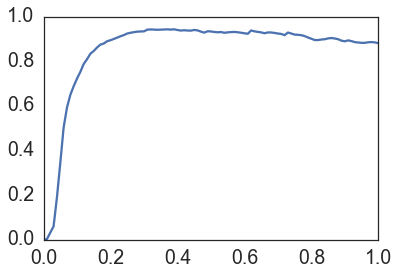

In [7]:
reload(Completeness)
dq = 0.01
comp_q = np.arange(0, 1+dq, dq)
completeness = np.zeros_like(comp_q)
N = np.zeros_like(comp_q)
with h5py.File('data/Completeness.h5', 'r') as f:
    for star, grp in f.iteritems():
        if star not in binary_starlist and star not in multiple_starlist:
            star_completeness = np.zeros((len(grp.keys()), comp_q.size))
            i = 0
            for date, dgrp in grp.iteritems():
                df = Completeness.get_completeness(star.encode(), date.encode()).sort_values(by='q')
                fcn = spline(df.q, df.Detection_Rate)
                good = (comp_q < df.q.max()) & (comp_q > df.q.min())
                star_completeness[i, good] = fcn(comp_q[good])
                i += 1
                #completeness[good] += fcn(comp_q[good])
                #N[good] += 1
            completeness += np.max(star_completeness, axis=0)
            N[good] += 1
            
# Set completeness = 0 at q = 0
completeness[0] = 0
N[0] = 1
plt.plot(comp_q, completeness/N)

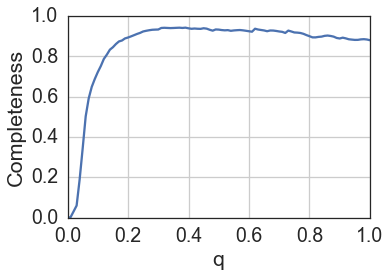

In [8]:
plt.figure()
plt.plot(comp_q, completeness/N)
plt.xlabel('q')
plt.ylabel('Completeness')
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.grid()
plt.savefig('Figures/SurveyCompleteness.pdf')
plt.savefig('Figures/SurveyCompleteness.jpeg')

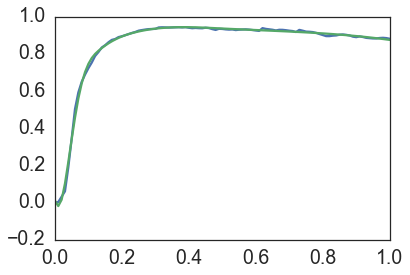

In [9]:
from scipy.interpolate import UnivariateSpline
plt.plot(comp_q, completeness/N)
smooth_comp_fcn = UnivariateSpline(comp_q, completeness/N, s=0.01)
plt.plot(comp_q, smooth_comp_fcn(comp_q))

## Apply the new histogram inference code

In [10]:
import MassRatioDistribution
bins = np.linspace(0, 1, 8)
comp_fcn = spline(comp_q, completeness / N)
class MyFitter(MassRatioDistribution.SmoothHistFitter):
    def __init__(self, *args, **kwargs):
        super(MyFitter, self).__init__(*args, **kwargs)
        self.malm_pars = np.array([-0.02042249,  0.04079731, -0.0227729 ,  0.01252475, -0.00095515, 0.00712293])
        self.malm_integrals = np.array([self._integrate_malmquist(self.malm_pars[::-1], q0, q1) for 
                                        (q0, q1) in zip(self.bin_edges[:-1], self.bin_edges[1:])])
        self.malm_fcn = np.poly1d(self.malm_pars)
        
    def _integrate_malmquist(self, malm_pars, q0, q1):
        """ Integrate the malmquist-correction factor from q0 --> q1
        """
        return np.sum([p/(i+1.0)*(q1**(i+1.0) - q0**(i+1.0)) for i, p in enumerate(malm_pars)])
    
    def censoring_fcn(self, q):
        return comp_fcn(q)
    
    def lnlike(self, pars):
        # Pull theta out of pars
        theta = pars[:self.Nbins]

        # Normalize theta
        # theta /= np.sum(theta * self.bin_widths)

        # Generate the inner summation
        gamma = np.ones_like(self.bin_idx) * np.nan
        good = (self.bin_idx < self.Nbins) & (self.bin_idx >= 0)  # nans in q get put in nonexistent bins
        gamma[good] = self.Nobs * self.censoring_fcn(self.qvals[good]) * theta[self.bin_idx[good]]
        
        # Malmquist-correct
        gamma *= self.malm_fcn(self.qvals) / np.sum(theta * self.malm_integrals)

        # Calculate the integral
        I = self._integral_fcn(theta)

        # Generate the log-likelihood
        summation = np.nanmean(gamma, axis=1)
        ll = -I + np.nansum(np.log(summation))
        return ll
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the bins uniformly, making sure they sum to 1
        for i in range(self.Nbins):
            cube[i] *= 10
        norm = np.sum(cube[:self.Nbins] * self.bin_widths)
        for i in range(self.Nbins):
            cube[i] /= norm
        
        # Sample the gaussian process hyperparameters uniformly
        cube[self.Nbins] = cube[self.Nbins] * 40 - 15
        cube[self.Nbins + 1] = cube[self.Nbins + 1] * 40 - 20
        cube[self.Nbins + 2] = cube[self.Nbins + 2] * 7 - 2
        cube[self.Nbins + 3] = cube[self.Nbins + 3] * 30 - 15
        return
    
shf = MyFitter(q, bin_edges=bins)
#shf = MassRatioDistribution.HistFitter(q, bin_edges=bins)

In [11]:
shf.smoothing = 10.0 # The default value is 6 for this dataset; this makes the smoothing prior less important
fit_pars = shf.guess_fit()

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


<Container object of 7 artists>

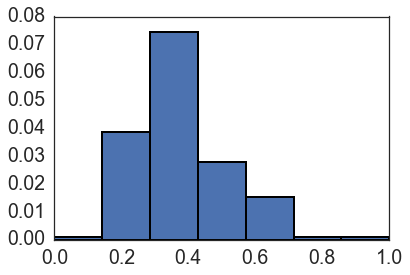

In [12]:
plt.bar(left=bins[:-1], width=shf.bin_widths, height=fit_pars[:-4], label='Fit', fill=True, lw=2)

In [13]:
shf.fit_multinest(basename='HistFitterTest/RealData_malmquist', overwrite=True)

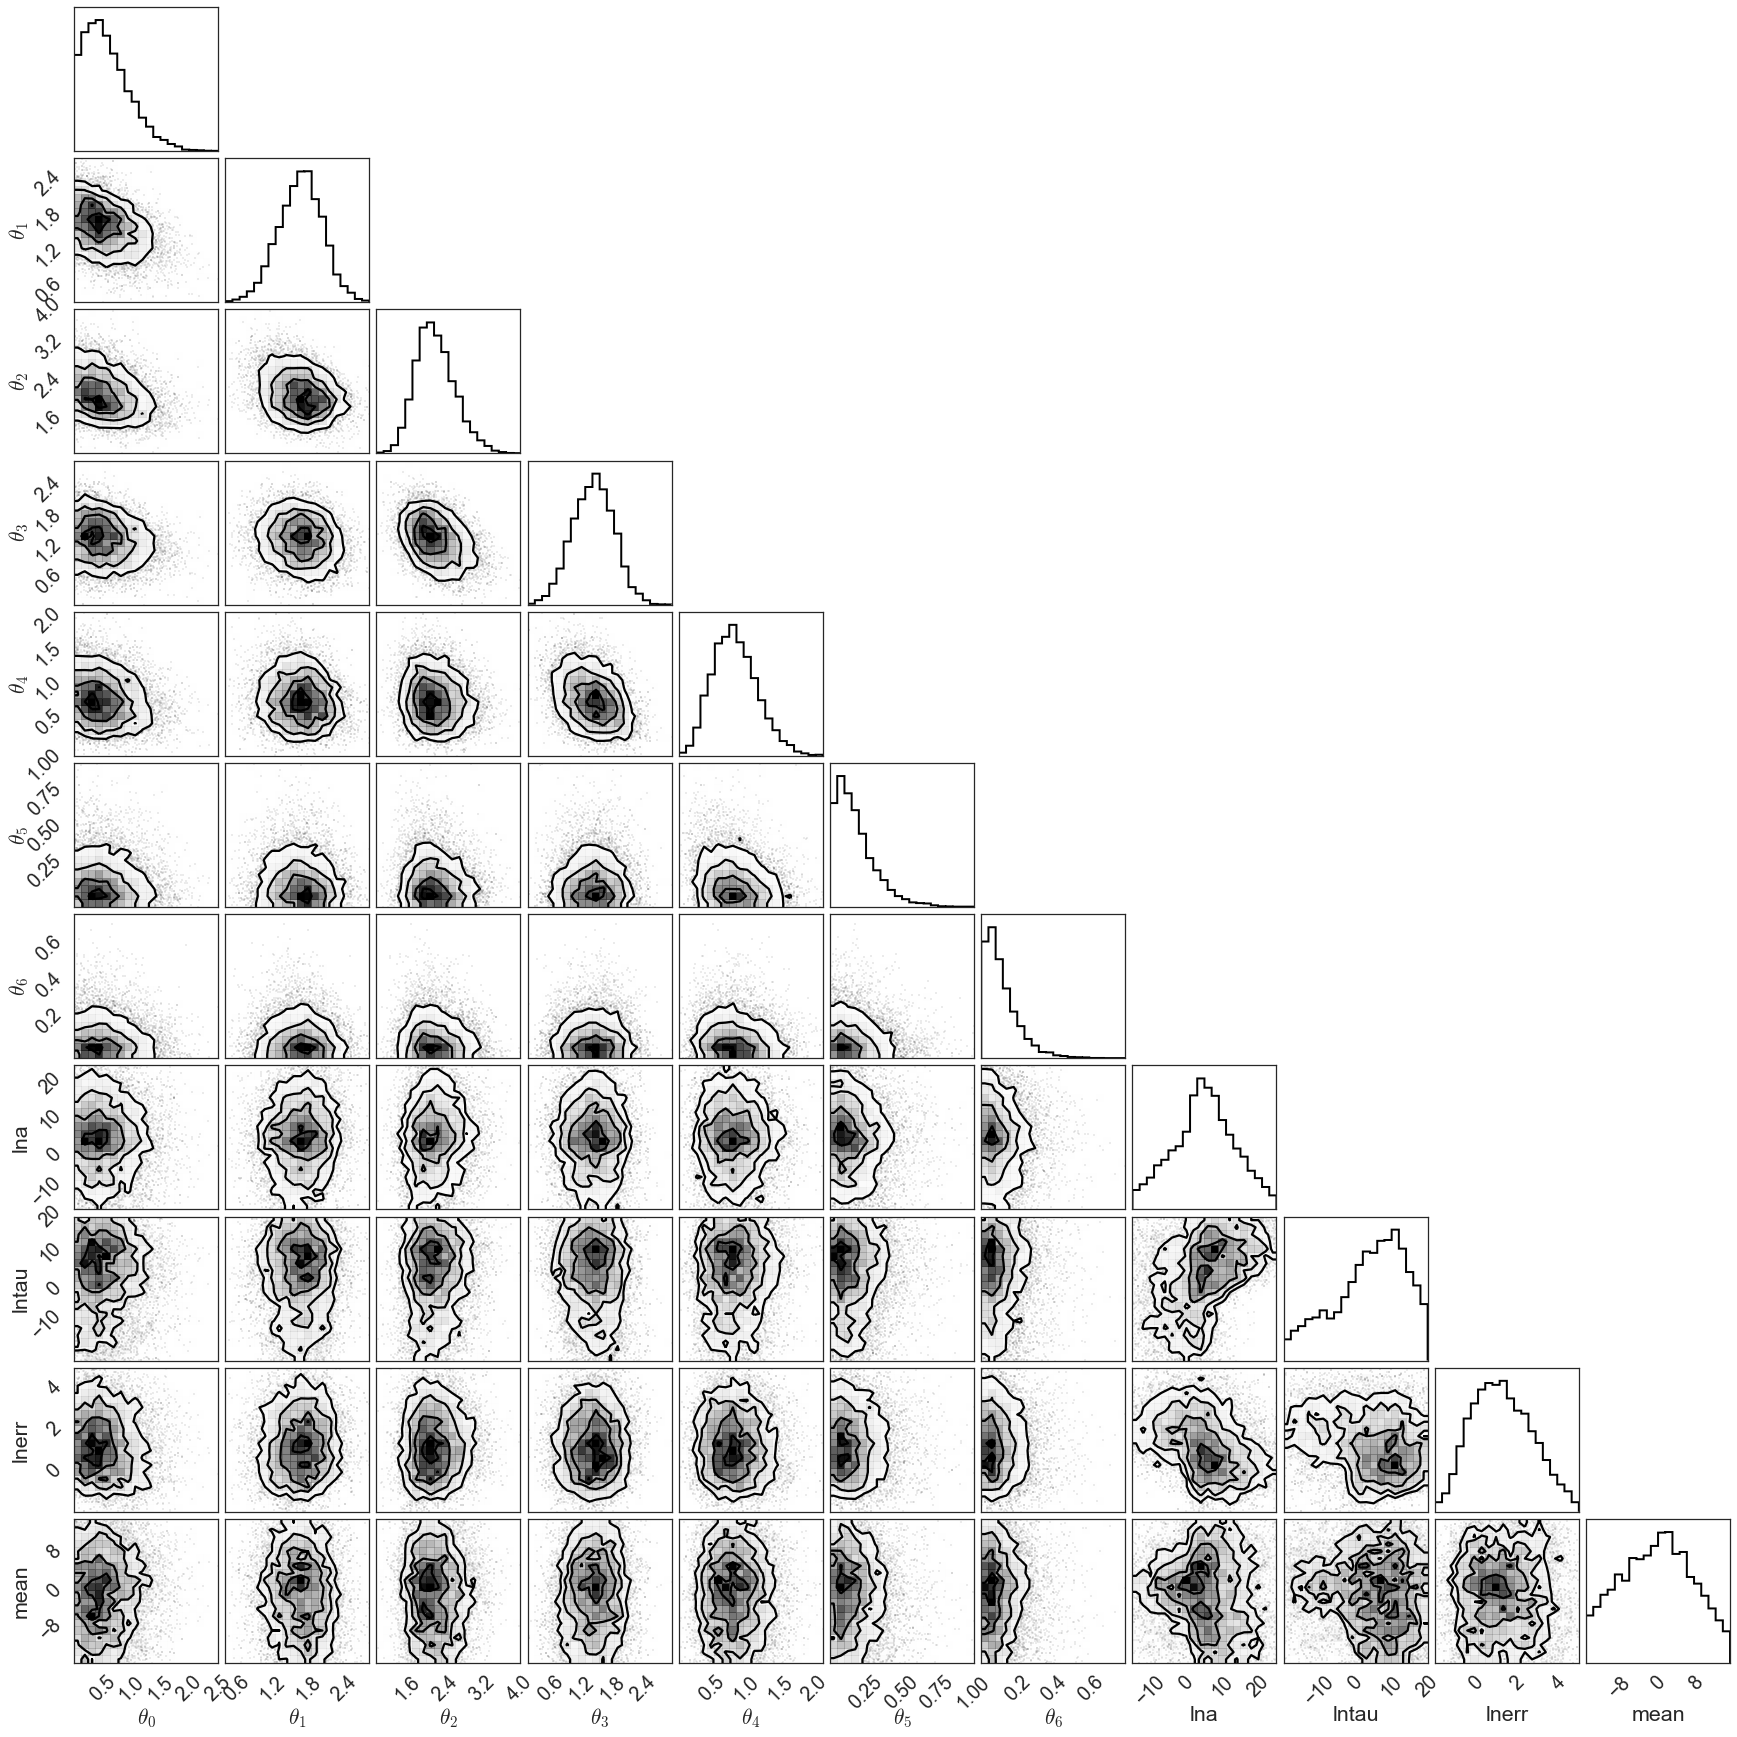

In [14]:
shf.triangle(hist_kwargs=dict(lw=2))

In [15]:
shf.samples.describe()

,$\theta_0$,$\theta_1$,$\theta_2$,$\theta_3$,$\theta_4$,$\theta_5$,$\theta_6$,lna,lnerr,lnprob,lntau,mean
count,8657.000000,8657.000000,8657.000000,8657.000000,8657.000000,8657.000000,8657.000000,8657.000000,8657.000000,8657.000000,8657.000000,8657.000000
mean,0.580790,1.670388,2.196887,1.422076,0.837427,0.180400,0.112030,4.942273,1.278737,151.927338,3.929105,-0.333078
std,0.391425,0.367827,0.418969,0.395999,0.327277,0.140861,0.092839,8.476273,1.431674,2.259726,9.694124,7.286348
min,0.000190,0.404870,0.932750,0.144391,0.008679,0.000098,0.000006,-14.992053,-1.995844,140.830196,-19.995276,-14.987242
25%,0.274859,1.425628,1.900616,1.147778,0.599935,0.077028,0.045436,-0.543061,0.192113,150.561493,-2.156048,-5.918989
50%,0.512703,1.683235,2.158002,1.432104,0.812021,0.146784,0.087891,5.020176,1.182361,152.203481,5.443107,-0.042729
75%,0.817509,1.919092,2.456970,1.701740,1.047874,0.245760,0.153824,10.605597,2.306123,153.577986,11.509617,5.158902
max,2.498571,2.826947,4.017087,2.957154,2.124837,1.006603,0.788791,24.968443,4.994460,156.840057,19.997465,14.977336


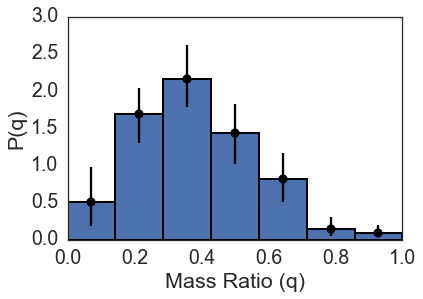

In [16]:
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='DFM Histogram', fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, m, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

# Make a normal histogram too, to compare
#mean_q = np.nanmean(q, axis=1)
#normal_heights, _ = np.histogram(mean_q, bins=bins, normed=True)
#plt.bar(left=bins[:-1], width=shf.bin_widths, height=normal_heights, label='Normal Histogram', fill=False, lw=2, edgecolor='r')
#plt.ylim((0, 4.0))

#from scipy import stats
#lt.plot(qvals, stats.norm.pdf(qvals, loc=0.35, scale=0.2), 'r-')

In [17]:
from kglib import fitters
from scipy.integrate import quad, romberg, fixed_quad, quadrature
from scipy.special import erf
from scipy.optimize import minimize, minimize_scalar

def get_lognormal_pars(mode, width):
    
    sigma = width
    mu = np.log(mode) + sigma**2
    return mu, sigma

class DistFitter(fitters.Bayesian_LS):
    def __init__(self, qvals):
        self.qvals = qvals
        self.lnq = np.log(qvals)
        self.completeness = self.completeness_fcn(self.qvals)
        self.Nobs = self.qvals.shape[0]
        self.setup_params()
        
        self.malm_pars = np.array([-0.02042249,  0.04079731, -0.0227729 ,  0.01252475, -0.00095515, 0.00712293])
        self.malm_fcn = np.poly1d(self.malm_pars)
    
    def completeness_fcn(self, q):
        return smooth_comp_fcn(q)
    
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        mu, sigma = pars
        A = 2.0 / (1 - erf(mu / (sigma * np.sqrt(2.0))))
        retval = A / (q * np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5 * (lnq - mu)**2 / sigma**2)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def setup_params(self):
        self.n_params = 2
        self.param_names = [r'$\mu$', r'$\sigma$']
    
    def _integrand(self, q, pars):
        return self.model(q, np.log(q), pars, use_cached_malmint=True) * self.completeness_fcn(q)
    
    def integral_fcn(self, pars):
        retval = quad(self._integrand, a=0, b=1.0, args=pars, maxp1=1000, limit=1000, limlst=1000)
        return retval[0] * self.Nobs
    
    def lnlike(self, pars):
        # Calculate gamma
        gamma = self.completeness * self.model(self.qvals, self.lnq, pars) * self.Nobs
        
        # Malmquist-correct
        #gamma *= self.malm_fcn(self.qvals) / self._malmquist_integral(pars)
        
        # Make the inner summation
        summand = np.nanmean(gamma, axis=1)
        summation = np.nansum(np.log(summand))
        
        return summation - self.integral_fcn(pars)
    
    def guess_fit_parameters(self, mode=0.4, width=0.3):
        mean, sigma = get_lognormal_pars(mode, width)
        def errfcn(p):
            return -self.lnlike(p)
        
        out = minimize(errfcn, (mean, sigma))
        mean, sigma = out.x
        return mean, sigma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the mean from -3 to 0 
        cube[0] = cube[0] * 3 - 3
        
        # Sample the width from 0.05 to 1
        cube[1] = cube[1] * 0.95 + 0.05
        return
    
    def predict(self, x, N=100, highest=False, malmcorr=False):
        """
        predict the y value for the given x values. Use the N most probable MCMC chains if highest=False,
        otherwise use the first N chains.
        """
        if self.samples is None:
            logging.warn('Need to run the fit method before predict!')
            return

        # Find the N best walkers
        if N == 'all':
            N = self.samples.shape[0]
        else:
            N = min(N, self.samples.shape[0])

        if highest:
            samples = self.samples.sort('lnprob', ascending=False)[:N]
        else:
            indices = np.random.randint(0, self.samples.shape[0], N)
            samples = self.samples.ix[indices]
        
        pars = samples[self.param_names].as_matrix()
        y = np.array([self.model(x, np.log(x), p, malmcorr=malmcorr) for p in pars])
        return y
    
    
    def _malmquist_integral(self, pars, use_cached=False):
        if use_cached:
            return self._malmquist_integral_cache
        else:
            def fcn(q):
                return self.model(q, np.log(q), pars, malmcorr=False) * self.malm_fcn(q)

            out = quad(fcn, a=0, b=1, maxp1=1000, limit=1000, limlst=1000)
            if out[1] / out[0] < 1e-4:
                self._malmquist_integral_cache = out[0]
                return out[0]
            print(pars)
            print(out)
            raise ValueError('Error on integration too large!')

    
class GaussianFitter(DistFitter):
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        mu, sigma = pars
        A = 2.0 / (erf(mu / (sigma * np.sqrt(2))) - erf((mu-1) / (sigma * np.sqrt(2))))
        retval = A / (np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5 * (q - mu)**2 / sigma**2)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, mode=0.4, width=0.3):
        def errfcn(p):
            retval = -self.lnlike(p)
            if np.isinf(retval):
                retval = 9e9
            return retval
        
        out = minimize(errfcn, (mode, width/2.0), bounds=((0, 1), (0.01, 1)))
        mean, sigma = out.x
        return mean, sigma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the mean from 0 to 1 
        cube[0] = cube[0] * 1.0
        
        # Sample the width from 0.01 to 3
        cube[1] = cube[1] * 3 + 0.01
        return
    
    
class PowerLawFitter(DistFitter):
    def setup_params(self):
        self.n_params = 1
        self.param_names = [r'$\gamma$',]
        
    def model(self, q, lnq, pars, malmcorr=True, use_cached_malmint=False):
        try:
            gamma = pars[0]
        except (TypeError, IndexError):
            gamma = pars
        #A = 2.0 / (erf(mu / (sigma * np.sqrt(2))) - erf((mu-1) / (sigma * np.sqrt(2))))
        #retval = A / (np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5 * (q - mu)**2 / sigma**2)
        retval = (1-gamma) * q**(-gamma)
        
        # Malmquist-correct:
        if malmcorr:
            retval *= self.malm_fcn(q) / self._malmquist_integral(pars, use_cached=use_cached_malmint)
        return retval
    
    def guess_fit_parameters(self, gamma=0):
        def errfcn(p):
            retval = -self.lnlike(p)
            if np.isinf(retval):
                retval = 9e9
            print(p, retval)
            return retval
        
        #out = minimize(errfcn, (gamma,), bounds=((-1, 1),))
        out = minimize_scalar(errfcn, bracket=(-0.5, 0.5), bounds=(-1, 1))
        gamma = out.x
        return gamma
    
    def mnest_prior(self, cube, ndim, nparams):
        # Sample the gamma from -1 to 1 
        cube[0] = cube[0] * 2.0 - 1.0
        
        return

## Fit the data to a normal distribution

In [23]:
def fit_data(function='gaussian', *args, **kwargs):
    if function.lower() == 'gaussian':
        df = GaussianFitter(q)
    elif function.lower() == 'lognormal':
        df = DistFitter(q)
    elif function.lower() == 'power':
        df = PowerLawFitter(q)
    
    df.fit_multinest(*args, **kwargs)
    df.triangle(hist_kwargs=dict(lw=2))
    return df

  analysing data from NormalFitter/RealData_malmquist.txt
log evidence = 150.4851 +/- 0.01244


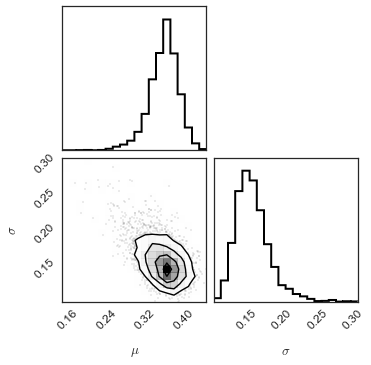

In [32]:
df = fit_data(function='gaussian',
              basename='NormalFitter/RealData_malmquist', overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))

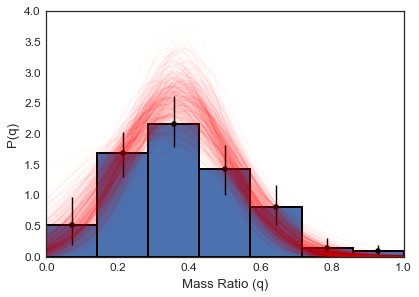

In [26]:
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='DFM Histogram', fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, m, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=plt.gca(), color='red', alpha=0.02)
plt.savefig('Figures/MRD_normal.pdf')
plt.savefig('Figures/MRD_normal.png')

## Fit to a log-normal

  analysing data from LogNormalFitter/RealData_malmquist.txt
log evidence = 151.6267 +/- 0.01208


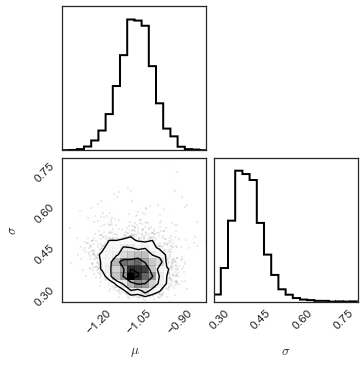

In [33]:
df = fit_data(function='lognormal',
              basename='LogNormalFitter/RealData_malmquist', overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))

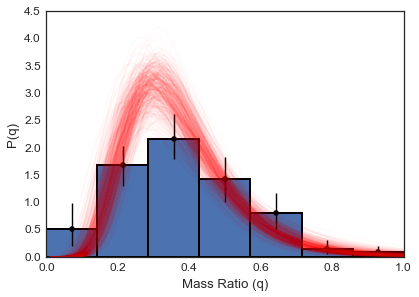

In [28]:
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='DFM Histogram', fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, m, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=plt.gca(), color='red', alpha=0.02)
plt.savefig('Figures/MRD_lognormal.pdf')
plt.savefig('Figures/MRD_lognormal.png')

## Fit to a power law

  analysing data from PowerLawFitter/RealData_malmquist.txt
log evidence = 130.5892 +/- 0.01039


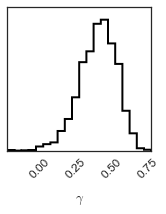

In [34]:
df = fit_data(function='power',
              basename='PowerLawFitter/RealData_malmquist', overwrite=False)
print('log evidence = {:.4f} +/- {:.5f}'.format(*df.evidence))

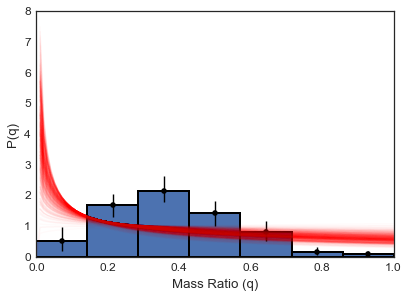

In [31]:
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='DFM Histogram', fill=True, lw=2, ecolor='k')
plt.plot(shf.bin_centers, m, 'ko')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('P(q)')

#plt.plot(qvals, df.model(qvals, np.log(qvals), (mean, sigma)), 'r-')
df.plot_samples(qvals, N=500, ax=plt.gca(), color='red', alpha=0.02)
plt.savefig('Figures/MRD_powerlaw.pdf')
plt.savefig('Figures/MRD_powerlaw.png')

# Old stuff. Don't use...

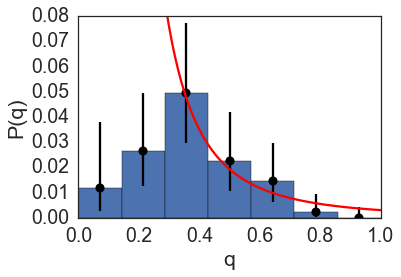

In [213]:
malm_pars = np.array([-0.02042249,  0.04079731, -0.0227729 ,  0.01252475, -0.00095515, 0.00712293])
hist.malmquist(malm_pars[::-1])
hist.plot()
plt.errorbar(hist.bin_centers, hist.malm_vals, 
             yerr=(hist.malm_vals-hist.malm_low, hist.malm_high-hist.malm_vals),
             fmt='ko')

plt.xlabel('q')
plt.ylabel('P(q)')
ylim = plt.ylim()
plt.plot(comp_q, 0.003*comp_q**(-2.68), 'r-')
plt.ylim(ylim)
plt.subplots_adjust(bottom=0.20, left=0.20)
plt.savefig('Figures/MRD.pdf')
plt.savefig('Figures/MRD.jpeg')

In [216]:
print( 0.003*0.25**(-2.68) / 0.03)

4.1069628722


In [136]:
from scipy import stats
from scipy import integrate

In [138]:
norm = integrate.quad(comp_fcn, 0, 1, maxp1=100)
comp_cdf = comp_fcn.antiderivative()
class CensoredUniform(stats.rv_continuous):
    def _pdf(self, x):
        return comp_fcn(x) / norm[0]
    
    def _cdf(self, x):
        return comp_cdf(x) / norm[0]

malm_fcn = spline(comp_q[good], completeness[good]/N[good] * np.poly1d(malm_pars)(comp_q[good]), ext=3)
malm_norm = integrate.quad(malm_fcn, 0, 1, maxp1=100)
malm_cdf = malm_fcn.antiderivative()
class MalmquistUniform(stats.rv_continuous):
    def _pdf(self, x):
        return malm_fcn(x) / malm_norm[0]
    
    def _cdf(self, x):
        return malm_cdf(x) / malm_norm[0]
        

KS, p = stats.kstest(mean_q[~np.isnan(mean_q)], 'uniform')
print('Probability of data being drawn from a uniform distribution = {:.3g}'.format(p))
KS, p = stats.kstest(mean_q[~np.isnan(mean_q)], CensoredUniform().cdf)
print('Probability of data being drawn from a uniform distribution (completesness-corrected) = {:.3g}'.format(p))
KS, p = stats.kstest(mean_q[~np.isnan(mean_q)], MalmquistUniform().cdf)
print('Probability of data being drawn from a uniform distribution (malmquist-corrected) = {:.3g}'.format(p))

Probability of data being drawn from a uniform distribution = 0.00132
Probability of data being drawn from a uniform distribution (completesness-corrected) = 0.000742
Probability of data being drawn from a uniform distribution (malmquist-corrected) = 4.34e-07


# What separation range we are sensitivite to for the detections?

Are we actually just seeing the outer distribution, or is this evidence that the inner distribution is *not* flat?

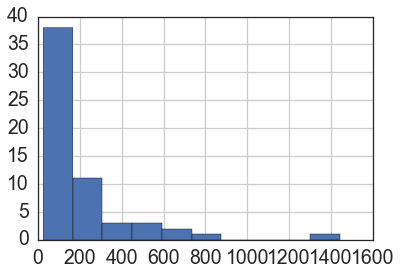

In [232]:
sample = HelperFunctions.read_observed_targets()
sample_stats = sample.loc[sample.identifier.isin(binary_starlist), ['identifier', 'Instrument', 'SpT', 'plx']].drop_duplicates(subset=['identifier', 'Instrument'])
sample_stats['distance'] = 1e3 / sample_stats.plx
sample_stats['ang_range'] = 3.0
sample_stats.loc[sample_stats.Instrument.isin(('TS23', 'IGRINS')), 'ang_range'] = 1.0
sample_stats.loc[sample_stats.Instrument == 'HRS', 'ang_range'] = 2.0

sample_stats['physical_range'] = sample_stats.ang_range * sample_stats.distance
sample_stats.physical_range.hist()

In [234]:
stats.percentileofscore(sample_stats.physical_range, 125)

42.622950819672127

Only 42% of my detections are guaranteed to be within 125 AU. What if I only look at the mass-ratio distribution for those companions?

In [236]:
close_binaries = sample_stats.loc[((sample_stats.physical_range.isnull()) | (sample_stats.physical_range < 150)) & (sample_stats.identifier.isin(binary_starlist)), 'identifier'].values
print(close_binaries)

[u'HIP 2548' u'HIP 5310' u'HR 545' u'HR 545' u'HIP 10732' u'HIP 12706'
 u'HIP 12706' u'HIP 12719' u'HIP 14764' u'HIP 14764' u'HIP 19949'
 u'HIP 20380' u'HIP 21589' u'HIP 21589' u'HIP 21589' u'HIP 22833'
 u'HIP 22833' u'HIP 23362' u'HIP 24902' u'HIP 25143' u'HIP 26126'
 u'HIP 32607' u'HIP 40881' u'HIP 76267' u'HIP 77336' u'HIP 80460'
 u'HIP 84606' u'HIP 93805' u'HIP 93805' u'HIP 100221' u'HIP 100907'
 u'HIP 103298' u'HIP 115115']


In [237]:
# Get the mass ratios for the close companions
prior_hdf5 = 'data/OrbitPrior.h5'
with h5py.File(prior_hdf5, 'r') as f:
    q_list = []
    M2_isolist = []
    M2_sptlist = []
    for starname, star_grp in f.iteritems():
        if starname in close_binaries:
            M1 = star_grp['primary'].value
            M2_spt = star_grp['companion_spectral_type'].value
            M2_iso = star_grp['companion_isochrone'].value
            M2_sptlist.append(M2_spt)
            q_list.append(M2_spt / M1)
    
    maxsize = max(a.size for a in q_list)
    q = np.ones((len(q_list), maxsize)) * np.nan
    M2 = np.ones((len(q_list), maxsize)) * np.nan
    for i, (qi, M2i) in enumerate(zip(q_list, M2_sptlist)):
        q[i][:qi.size] = qi
        M2[i][:M2i.size] = M2i

mean_q = np.nanmedian(q, axis=1)
mean_q = mean_q[~np.isnan(mean_q)]

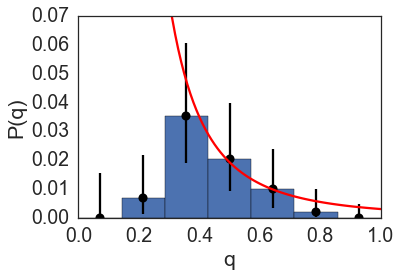

In [239]:
# Make the histogram
bins = np.linspace(0, 1, 8)
hist = Hist(mean_q, bins, Nsamp=360)

# Completeness-correct it
good = N > 0
comp_fcn = spline(comp_q[good], completeness[good]/N[good], ext=3)
hist.completeness(completeness_fcn=comp_fcn)

# Malmquist-correct it
malm_pars = np.array([-0.02042249,  0.04079731, -0.0227729 ,  0.01252475, -0.00095515, 0.00712293])
hist.malmquist(malm_pars[::-1])

# Plot
hist.plot()
plt.errorbar(hist.bin_centers, hist.malm_vals, 
             yerr=(hist.malm_vals-hist.malm_low, hist.malm_high-hist.malm_vals),
             fmt='ko')

plt.xlabel('q')
plt.ylabel('P(q)')
ylim = plt.ylim()
plt.plot(comp_q, 0.003*comp_q**(-2.68), 'r-')
plt.ylim(ylim)
plt.subplots_adjust(bottom=0.20, left=0.20)



# Conclusion:

The power law at large mass-ratios holds true even when we only consider close companions. The inner mass-ratio distribution is emphatically **not** flat!

# Orbit fitting

In [72]:
import h5py
from astropy.modeling import models, fitting

In [75]:
rv_df = pd.read_csv('data/Master_RV.csv', quotechar="'")
for col in ['RV1', 'RV1_err', 'RV2', 'RV2_err', 'RV3', 'RV3_err']:
    rv_df[col] = pd.to_numeric(rv_df[col], errors='coerce')
rv_df.head()

,star,HJD,RV1,RV1_err,RV2,RV2_err,RV3,RV3_err,bibcode,Notes
0,HIP 100221,2456523.78705,-28.332246,3.013508,NaN,NaN,NaN,NaN,This Study,NaN
1,HIP 100221,2457230.72294,-3.550911,10.039749,0.796587,0.178684,NaN,NaN,This Study,NaN
2,HIP 100907,2456946.57153,0.379850,10.039494,4.290126,0.173792,NaN,NaN,This Study,NaN
3,HIP 100907,2457230.67163,12.706238,10.021763,4.326954,0.105397,NaN,NaN,This Study,NaN
4,HIP 103298,2456946.58150,12.558334,10.037995,9.564706,0.104491,NaN,NaN,This Study,NaN


In [78]:
imaging_df = pd.read_excel('/home/kgullikson/Dropbox/School/Research/Databases/Imaging/WDS_Imaging_Data_Checked.xls', sheetname='WDS_Imaging_Data')
imaging_df.head()

,star,wds,wds_base,wds_comp,wds_y,epoch_flg,epoch,pa_flg,pa,pa_err_flg,...,mag2_err,filt_lam,filt_fwhm,filt_flg,aperture,aperture_flg,nights,refcode,tech_code,WDS
0,HIP 1366,WDS J00171+3841AB,WDS J00171+3841,AB,00171+3841,NaN,1986.8969,NaN,141.6,NaN,...,NaN,549,22,NaN,3.8,NaN,1,McA1989,Sc,WDS J00171+3841
1,HIP 1366,WDS J00171+3841AB,WDS J00171+3841,AB,00171+3841,NaN,1989.7174,NaN,156.7,NaN,...,NaN,549,22,NaN,3.8,NaN,1,Hrt1992b,Sc,WDS J00171+3841
2,HIP 1366,WDS J00171+3841AB,WDS J00171+3841,AB,00171+3841,NaN,1991.8934,NaN,143.8,NaN,...,NaN,549,22,NaN,3.8,NaN,1,McA1993,Sc,WDS J00171+3841
3,HIP 1366,WDS J00171+3841AB,WDS J00171+3841,AB,00171+3841,NaN,1991.9016,NaN,143.9,NaN,...,NaN,508,41,a,3.8,NaN,2,McA1993,Sc,WDS J00171+3841
4,HIP 1366,WDS J00171+3841AB,WDS J00171+3841,AB,00171+3841,NaN,1996.5378,:,141.3,NaN,...,NaN,549,22,NaN,2.5,NaN,1,Hrt2000a,Sc,WDS J00171+3841


In [74]:
ls -lah /home/kgullikson/Dropbox/School/Research/Databases/Imaging/

total 22M
drwxr-xr-x 2 kgullikson kgullikson 4.0K Dec 15 18:00 ./
drwxr-xr-x 7 kgullikson kgullikson 4.0K Nov 12 15:30 ../
-rw-r--r-- 1 kgullikson kgullikson 1.9K Nov 17 15:33 compile_literature_rvs.py
-rw-r--r-- 1 kgullikson kgullikson 2.5K Nov 17 13:27 compile_literature_rvs.pyc
-rw-r--r-- 1 kgullikson kgullikson  60K Nov 13 11:41 WDS_Imaging_Data_Checked.csv
-rw-r--r-- 1 kgullikson kgullikson 2.3M Dec 15 18:00 WDS_Imaging_Data_Checked.xls
-rw-r--r-- 1 kgullikson kgullikson  46K Nov 12 16:43 WDS_Imaging_Data.csv
-rw-r--r-- 1 kgullikson kgullikson 465K Nov 17 13:40 WDS_Interferometry_Imaging_Data.csv
-rw-r--r-- 1 kgullikson kgullikson  19M Nov 12 15:30 WDS_Interferometry_Normalized.csv


In [119]:
def get_initial_guess(starname, ax=None):
    # Get the subset of the master RVs with this star
    subset = rv_df.loc[rv_df.star == starname, ['HJD', 'RV1', 'RV1_err', 'RV2', 'RV2_err', 'RV3', 'RV3_err']].copy()
    good = (subset.RV1.notnull()) & (subset.RV2.notnull())
    rv1 = subset.loc[good, 'RV1'].values
    rv2 = subset.loc[good, 'RV2'].values
    rv1_err = subset.loc[good, 'RV1_err'].values
    rv2_err = subset.loc[good, 'RV2_err'].values
    if len(rv1) < 1:
        return np.nan, np.nan
    
    # Fit using astropy
    l_init = models.Linear1D()
    fitter = fitting.LinearLSQFitter()
    
    l = fitter(l_init, x=rv1, y=rv2)
    a, b = l.parameters
    q = -1/a
    gamma = b/(1+q)
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.errorbar(rv1, rv2, xerr=rv1_err, yerr=rv2_err, fmt='ko')
    x = np.array(ax.get_xlim())
    y = a*x + b
    ax.plot(x, y)
    return q, gamma


def get_prior(starname, mass_type='spectral type'):
    with h5py.File('data/OrbitPrior.h5', 'r') as f:
        if starname in f.keys():
            grp = f[starname]
            M1 = grp['primary'].value
            if 'spectral' in mass_type.lower():
                M2 = grp['companion_spectral_type'].value
            else:
                M2 = grp['companion_isochrone'].value
            
            return M2/M1
        else:
            print('Starname ({}) not found!'.format(starname))
            return None
            
def get_data(starname):
    """ Get the rv and imaging data for this star
    """
    # RV data
    rv_subset = rv_df.loc[rv_df.star == starname, ['HJD', 'RV1', 'RV1_err', 'RV2', 'RV2_err', 'RV3', 'RV3_err']].copy()
    good = (rv_subset.RV1.notnull())# & (rv_subset.RV2.notnull())
    rv1 = rv_subset.loc[good, 'RV1'].values
    rv2 = rv_subset.loc[good, 'RV2'].values
    rv1_err = rv_subset.loc[good, 'RV1_err'].values
    rv2_err = rv_subset.loc[good, 'RV2_err'].values
    t_rv = rv_subset.loc[good, 'HJD'].values
    
    # Imaging data
    im_subset = imaging_df.loc[imaging_df.star == starname, ['epoch', 'wds_comp', 'pa', 'pa_err', 'sep', 'sep_err']].copy()
    good = (im_subset.pa.notnull()) & (im_subset.sep.notnull())
    pa = im_subset.loc[good, 'pa'].values
    sep = im_subset.loc[good, 'sep'].values
    pa_err = im_subset.loc[good, 'pa_err'].values
    sep_err = im_subset.loc[good, 'sep_err'].values
    component = im_subset.loc[good, 'wds_comp'].values
    if pa.size > 1:
        t_im = Time(im_subset.loc[good, 'epoch'], format='decimalyear').jd
    else:
        t_im = np.array([])
    
    return t_rv, rv1, rv2, rv1_err, rv2_err, t_im, component, pa, sep, pa_err, sep_err

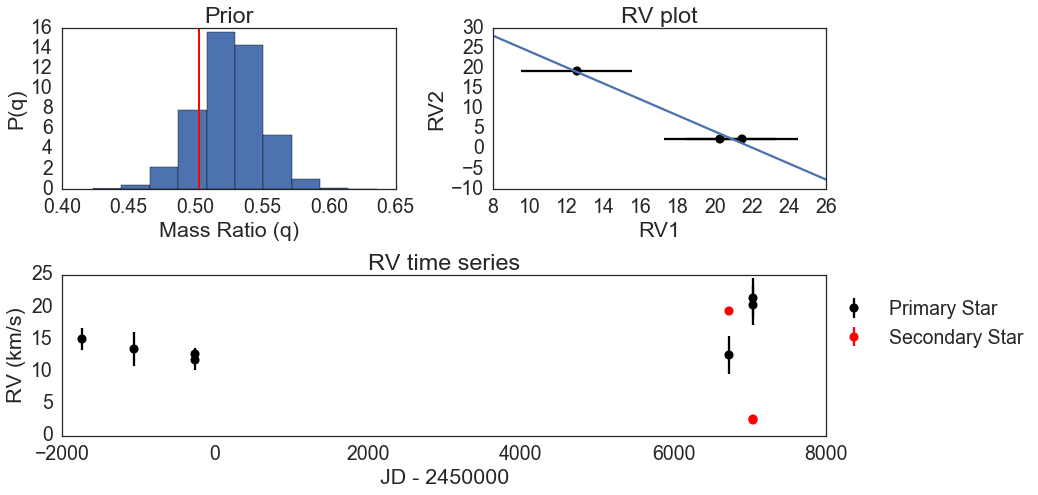

In [123]:
# Get the mass-ratio prior and initial guess
from matplotlib import gridspec
t_rv, rv1, rv2, rv1_err, rv2_err, t_im, component, pa, sep, pa_err, sep_err = get_data('HIP 32607')
q_prior = get_prior('HIP 32607')

fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
_ = ax1.hist(q_prior[~np.isnan(q_prior)], normed=True)

q, gamma = get_initial_guess('HIP 32607', ax=ax2)

ax1.plot((q, q), ax1.get_ylim(), 'r-', lw=2)
ax3.errorbar(t_rv-2450000, rv1, yerr=rv1_err, fmt='ko', label='Primary Star')
ax3.errorbar(t_rv-2450000, rv2, yerr=rv2_err, fmt='ro', label='Secondary Star')

ax1.set_xlabel('Mass Ratio (q)')
ax1.set_ylabel('P(q)')
ax2.set_xlabel('RV1')
ax2.set_ylabel('RV2')
ax3.set_xlabel('JD - 2450000')
ax3.set_ylabel('RV (km/s)')
ax1.set_title('Prior')
ax2.set_title('RV plot')
ax3.set_title('RV time series')
ax3.legend(loc=(1, 0.5))

plt.tight_layout()

In [121]:
ax3.legend?

In [124]:
for star in rv_df.star.unique():
    print(star)
    # Get the data
    t_rv, rv1, rv2, rv1_err, rv2_err, t_im, component, pa, sep, pa_err, sep_err = get_data(star)
    
    # Get the prior
    q_prior = get_prior(star)
    if q_prior is None:
        continue
    
    # Plot
    fig = plt.figure(figsize=(12,7))
    gs = gridspec.GridSpec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    _ = ax1.hist(q_prior[~np.isnan(q_prior)], normed=True)

    q, gamma = get_initial_guess(star, ax=ax2)
    if q is np.nan and gamma is np.nan:
        plt.close('all')
        continue

    #ax1.plot((q, q), ax1.get_ylim(), 'r-', lw=2)
    ax3.errorbar(t_rv-2450000, rv1, yerr=rv1_err, fmt='ko', label='Primary Star')
    ax3.errorbar(t_rv-2450000, rv2, yerr=rv2_err, fmt='ro', label='Secondary Star')
    
    ax1.set_xlabel('Mass Ratio (q)')
    ax1.set_ylabel('P(q)')
    ax2.set_xlabel('RV1')
    ax2.set_ylabel('RV2')
    ax3.set_xlabel('JD - 2450000')
    ax3.set_ylabel('RV (km/s)')
    ax1.set_title('Prior')
    ax2.set_title('RV plot')
    ax3.set_title('RV time series')
    ax3.legend(loc=(1, 0.5))
    
    plt.tight_layout()
    fig.savefig('Figures/DataPlots/{}.pdf'.format(star.replace(' ', '_')))
    plt.close('all')

HIP 100221
HIP 100907
HIP 103298
HIP 105942
Starname (HIP 105942) not found!
HIP 10732
HIP 109139
HIP 109521
HIP 111841
Starname (HIP 111841) not found!
HIP 115115
HIP 12332
HIP 12706
HIP 12719
Starname (HIP 12719) not found!
HIP 13165
HIP 13327
HIP 14576
HIP 14764
HIP 16244
HIP 16340
HIP 16611
HIP 17563
HIP 18396
HIP 18724
HIP 19949
HIP 20380
HIP 21589
HIP 22833
HIP 22958
HIP 23362
HIP 23916
HIP 24244
HIP 24902
HIP 25048
Starname (HIP 25048) not found!
HIP 25143
HIP 2548
HIP 26063
Starname (HIP 26063) not found!
HIP 26126
HIP 28691
Starname (HIP 28691) not found!
HIP 32607
HIP 33575
Starname (HIP 33575) not found!
HIP 3478
HIP 37322
Starname (HIP 37322) not found!
HIP 37450
HIP 38538
HIP 38593
HIP 38846
HIP 39847
HIP 40881
HIP 42129
HIP 46283
HIP 51362
HIP 52678
HIP 5310
HIP 5348
Starname (HIP 5348) not found!
HIP 55266
HIP 63945
HIP 72154
HIP 76267
HIP 77336
HIP 77516
HIP 78820
HIP 78821
HIP 79199
HIP 79404
HIP 80460
HIP 82673
HIP 84606
HIP 85379
HIP 8704
Starname (HIP 8704) not foun